PyFWI Within PyTorch
=====================


PyFWI is integrated with PyTorch to provide the gradient of a cost function with respect to model parameters. Here, a simple example is provided to show the application of this integration. This notebook can be compared to the [Simple Example](https://pyfwi.readthedocs.io/en/latest/sub_doc/example.html) for a better understanding of the required changes and the results.

In this section, we first show the forward modeling, and then we estimate the gradient of the cost function with respect to $V_P$.


 **1. Forward modeling**



In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages and modulus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.fwi_tools as tools
import PyFWI.processing as process

import torch
from PyFWI.torchfwi import Fwi


A simple model can be created by using ```model_dataset``` module as

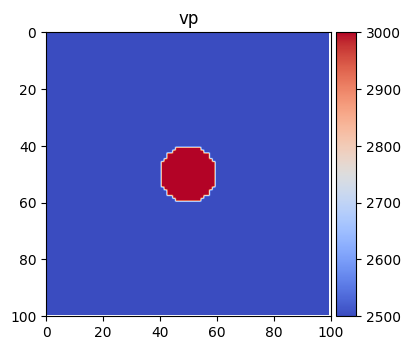

In [2]:
Model = md.ModelGenerator('louboutin')
model = Model()
# Making medium acoustic
model['vs'] *= 0.0
model['rho'] = np.ones_like(model['rho'])

im = splt.earth_model(model, ['vp'], cmap='coolwarm')

Then we need to create an input dictionary as follow

In [3]:
model_shape = model[[*model][0]].shape

inpa = {
    'ns': 5,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 1,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.8,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
    'seimogram_shape': '3d',
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc = acq.surface_seismic(inpa['ns'], inpa['rec_dis'], offsetx,
                                                      inpa['dh'], inpa['sdo'])        
src_loc[:, 1] -= 5 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Model properties should be with type of `torch.tensor`. So, we need to convert these properties.

In [5]:
vp = torch.tensor(model['vp'])
vs = torch.tensor(model['vs'])
rho = torch.tensor(model['rho'])

Finally, we can have the forward modelling as 

In [6]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape, components=seisout)

# Call the forward modelling 
taux_obs, tauz_obs = Fwi.apply(W, vp, vs, rho)  # show=True can show the propagation of the wave

To compute the gradient using the adjoint-state method, we need to save the wavefield during the forward wave propagation. This must be done for the wavefield obtained from estimated model. 
For example, the wavefield at four time steps are presented here in addition to a shot gather. 

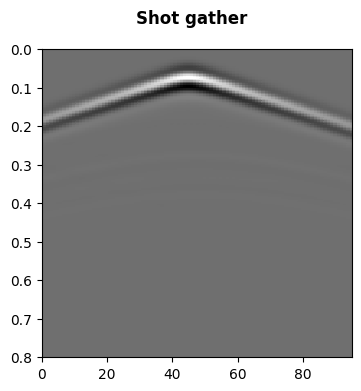

In [7]:
fig = plt.figure(figsize=(4, 4))

ax = fig.add_subplot(111)
ax = splt.seismic_section(ax, taux_obs[..., 2], t_axis=np.linspace(0, inpa['t'], int(1 + inpa['t'] // inpa['dt'])))

fig.suptitle("Shot gather", fontweight='bold');


**2. Gradient**

To compute the gradient, we need the observed data and an initial model. 


**Note:** For better visualization and avoiding crosstalk, I compute the gradient in acoustic media.

Then we create the initial model.

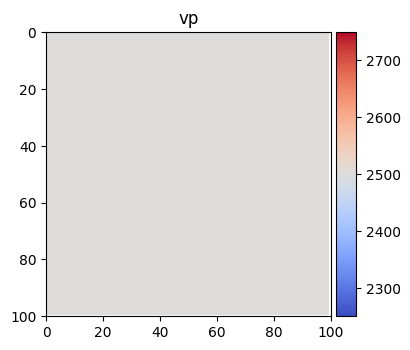

In [8]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(model['rho'])

# Convert to tensor
vp0 = torch.tensor(m0['vp'], requires_grad=True)
vs0 = torch.tensor(m0['vs'], requires_grad=True)
rho0 = torch.tensor(m0['rho'], requires_grad=True)

im = splt.earth_model(m0, ['vp'], cmap='coolwarm')

And we simulate the wave propagation to obtain estimated data.
For computing the gradient, we can smooth the gradient and scale it by defining `g_smooth` and `energy_balancing`.


In [9]:
inpa['energy_balancing'] = True

We save the wavefield at 20% of the time steps  (`chpr = 20`) to be used for gradient calculation. The value of wavefield is accessible using the attribute ```W``` which is a dictionary for $V_x$, $V_z$, $\tau_x$, $\tau_z$, and $\tau_{xz}$ as ```vx```, ```vz```, ```taux```, ```tauz```, and ```tauxz```.
Each parameter is a 4D tensor. For example, we can have access to the last time step of $\tau_x$ for the first shot as ```W.W['taux'][:, :, 0, -1]```.

In [10]:
Lam = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                          chpr=20, components=seisout)

taux_est, tauz_est = Fwi.apply(Lam,
                               vp0,
                               vs0, 
                               rho0
                               )


Now, we define the cost function and obtaine the residuals for adjoint-state method.

In [11]:
criteria = torch.nn.MSELoss(reduction='sum')
mse0 = 0.5 * criteria(taux_est, taux_obs)
mse1 = 0.5 * criteria(tauz_est, taux_obs)
mse = mse0 + mse1
# print(mse.item())
mse.backward()

Using the adjoint source, we can estimate the gradient as 

In [12]:
grad = {'vp': vp0.grad,
        'vs': vs0.grad,
        'rho':rho0.grad
        }

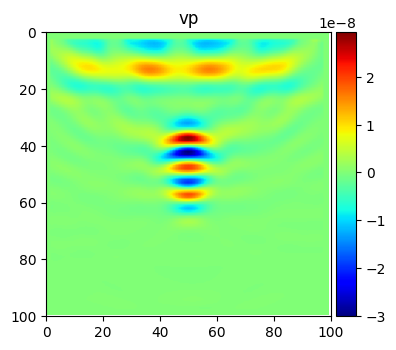

In [13]:
# Time to plot the results
splt.earth_model(grad, ['vp'], cmap='jet');
